In [6]:
import copy
import gc
import calendar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder  


Load saved cleaned df 

In [7]:
facility_data = pd.read_csv('preprocessed_site_data.csv') 

facility_data['Timestamp'] = pd.to_datetime(facility_data.Timestamp, format='%Y-%m-%d %H:%M:%S')
facility_data['date'] =facility_data['Timestamp'].dt.date

facility_data.index= facility_data.Timestamp

In [12]:
np.sum(facility_data.Values.isnull())

1

In [13]:
def make_validation_features(data, val_not_test=True, val_cutoff='1-1-2017 00:00:00', test_cutoff='6-19-2017 23:59:59'):
    """Takes the preprocessed data creates features for ML with validation/test split indicates"""
    
    if val_not_test:   
        train = make_features(data[:val_cutoff].copy())
        train['data_set'] = 0
        
        test = make_features(data[:test_cutoff].copy())[val_cutoff:]
        test['data_set'] = 1
        
    else:
        train = make_features(data[:test_cutoff].copy())
        train['data_set'] = 0
        
        test = make_features(data.copy())[test_cutoff:]
        test['data_set'] = 3
        
    target = pd.concat([train, test])
    return target

def make_features(target):
    """makes features for ML without val/test split"""
    
    #record length to check nothing unexpected occurs later
    target_length = target.shape[0]
    
    #add one hot encoded day of week
    DofW = pd.get_dummies(target.DofW)
    DofW.columns = list(calendar.day_abbr)
    DofW.head()
    target = pd.merge(target, 
                     DofW,
                     how= 'left',
                     left_index=True, right_index=True)
    
    assert target.shape[0] == target_length
    
    
    
    holid_type_list = ['dayB4Holiday', 'isHoliday', 'dayAftHoliday']
    
    target['holid_group'] = (target[holid_type_list].sum(axis=1) > 1)
    target['holid_group'] = target.holid_group.astype(int)
    target['winter_holid'] = (((target['month'] == 12 ) & (target['day'] > 21)) |
                           ( (target['month'] == 1) & (target['day'] <=1)))
    target['winter_holid'] = target.winter_holid.astype(int)

    #add average value for capturing seasonal effects
    # day of year and hour average to be used for edge cases
    temp = target.groupby(['DofY','hour'], as_index=False).apply(mean_of_others_day).reset_index()
    temp.index = temp.Timestamp
    temp.sort_index(inplace=True)
    target['temp_daily_av'] = temp['Values']

    # day of week and week of year, except edge cases with only one value
    temp = target.groupby(['week','DofW','hour']).apply(mean_of_others_week).reset_index()
    temp.index= temp.Timestamp
    temp.sort_index(inplace=True)
    target['hour_av'] = temp[0]
    target.drop('temp_daily_av', axis=1, inplace=True)

    # temperature features
    target['kelv'] = target['wtd_temp'] - target['wtd_temp'].mean()
    target['kelv2'] = target['kelv'] ** 2    
    target['wtd_temp'] = target['wtd_temp'] - 18

    #temperature day of year and hour global average
    target['hourly_av_T'] = target.groupby(['DofY','hour'])['wtd_temp'].transform(np.mean)
    target['hourly_av_T2'] = target.groupby(['DofY','hour'])['kelv2'].transform(mean_sq_temp)

    target['diff_from_av'] = target.Values - target['hour_av']
    target['diff_from_av_T'] = target.wtd_temp - target['hourly_av_T']
    target['diff_from_av_T2'] = target['kelv2'] - target['hourly_av_T2']
    assert target.shape[0] == target_length
       
    # create several diff features to shift back to prior weeks
    orig_names = list(target)
    #differences
    target['f1d4_Values'] = target['Values'].diff(4)
    target['bd1_Values'] = target['Values'].diff(-4)
    target['f1d1_Values'] = target['Values'].diff(2)
    #use prior column names and current to get new col names 
    imp_col_names = list(set(list(target)) - set(orig_names))
    print(imp_col_names)
    # add shifted differences
    target = add_shifted(target, imp_col_names, 1, 'D')
    target = add_shifted(target, imp_col_names, 7, 'D')
    

    #peak hour which is shifted back
    peak_hour = target.groupby('date')[['Values']].agg(find_daily_max_demand_time)
    peak_hour.reset_index(inplace=True)
    peak_hour['date'] = peak_hour['date'].astype(str)
    peak_hour['Values'] = peak_hour.Values.dt.hour + peak_hour.Values.dt.minute/60
    peak_hour.rename(columns={'Values':'peak_hour'},inplace=True)
    assert target.shape[0] == target_length
    
    
    #add predicted daily values
    daily_pred = pd.read_csv('day_predictions.csv')
    daily_pred.rename(columns={'pred':'daily_pred'},inplace=True)

    target['date2'] = target.date
    target['date']= target.date.astype(str)
    target = pd.merge(target, daily_pred[['daily_pred','daily_av','date']],
             left_on='date', right_on='date',how='left')

    #add peak hour for prior day
    target = pd.merge(target, peak_hour,
             left_on='date', right_on='date',how='left')

    target['date'] = target.date2
    target.index = target.Timestamp
    target['dist_from_peak'] = target['hour'] - target['peak_hour']
    target.drop('date2', axis=1, inplace=True)
    assert target.shape[0] == target_length
    
    #shift the values back by days
    shifts = [1,2,3,7,52*7]
    for shft in shifts: 

        #shift values
        val_col_name = 'p'+str(shft)+'shft'
        target[val_col_name] = shift_column(target, 'diff_from_av',shift_amt=shft)

        #shift peak
        val_col_name2 = 'peak'+str(shft)+'shft'
        target[val_col_name2] = shift_column(target, 'dist_from_peak',shift_amt=shft)

        #shift temperatures
        tem_col_name = 't'+str(shft)+'shft'
        target[tem_col_name] = shift_column(target, 'kelv2', shift_amt=shft )

    #difference between prior weeks temperature
    target['p1shft_d'] = target['kelv2'] - target['p1shft']
    target['p7sfht_d'] = target['kelv2'] - target['p7shft']

    target['diff_from_av_T'] = target.wtd_temp - target['hourly_av_T']
    target['diff_from_av_T_sq'] = target.wtd_temp**2 - target['hourly_av_T']**2
    target['temp_streak_av'] = target.diff_from_av_T_sq.ewm(span=12).mean()
    target['temp_streak'] = target.rolling(8)['diff_from_av_T'].agg(sum)
    target['diff_rat'] = target.diff_from_av/(target.temp_streak_av.apply(abs)+1)
    target['daily_pred_av_ratio'] = target['daily_pred'] / target['daily_av']
    target.index = target['Timestamp']
    target.dropna(subset=['Values'],inplace=True)
    assert target.shape[0] == (target_length - 1) #the initial value should be a null and dropped
    

    cats = ['hour']

    target = pd.merge(target,
            pd.get_dummies(target[cats], columns = cats),
            left_index=True, right_index=True, how='left')
    
    target.index = target['Timestamp']

    # save feature lists of features to remove for the 1 day and 1 hr ahead versions
    target['ahead_15'] = target['diff_from_av'].shift(1)
    target['ahead_15_diff'] = target['ahead_15'].diff(1)
    target['ahead_30'] = target['diff_from_av'].shift(2)
    target['1hr_ahead'] = target['diff_from_av'].shift(4)
    target['1hr_ahead_diff'] = target['1hr_ahead'].diff(2)
    target['1hr_ahead_diff_diff'] = target['1hr_ahead_diff'].diff()
    target['1p5hr_ahead'] = target['diff_from_av'].shift(6)
    target['2hr_ahead'] = target['diff_from_av'].shift(8)
    
    return target
    

#temp squared
def mean_sq_temp(col):
    return np.mean(col**2)

#lags
def add_lag(df, col, lag=3):
    col_name ='l'+ str(lag) + col
    df[col_name] = df[col].shift(lag)
    return col_name

def return_first(col):
    if col.shape[0]:
        return col.iloc[0]
    else:
        return np.nan
    #prior days
    
def merge_date_inds(df1, df2):
    return pd.merge(df1,
            df2,
            left_index = True, right_index=True,
            how='left')
    
def add_shifted(df, cols, amd, unit):
    
    toshift = df.loc[:,cols].copy()
    toshift.index=toshift.index+pd.Timedelta(amd, unit=unit)
    toshift.columns = [('shift_'+str(amd) + unit+col_name) for col_name in cols]
    return merge_date_inds(df, toshift)

def find_daily_max_demand_time(groupby_cols):
    return groupby_cols.idxmax()

def shift_column(df, column_name='Values', shift_amt=1):
    return df.groupby('hour',as_index=False)[column_name].transform(lambda col: col.shift(shift_amt))

def mean_of_others_day(col):

    if col.Values.shape[0] > 1:
        temp = (np.sum(col.Values) - col.Values)/(col.Values.shape[0] - 1)
        assert temp.shape[0] == col.shape[0]
        return temp
    else:
        raise

def mean_of_others_week(col):
    if col.Values.shape[0] > 1:
        return (np.sum(col.Values) - col.Values)/(col.Values.shape[0] - 1)
    else:       
        return col.temp_daily_av
    

In [26]:
feats_df = make_validation_features(facility_data, True )
print(feats_df.data_set.value_counts())
feats_df.shape

['f1d4_Values', 'f1d1_Values', 'bd1_Values']
['f1d4_Values', 'f1d1_Values', 'bd1_Values']
0    222152
1     16320
Name: data_set, dtype: int64


(238472, 175)

In [27]:
feats_df.to_csv('final_data/train_val.csv',index=False)
# feats_df.to_csv('final_data/train_test.csv',index=False)


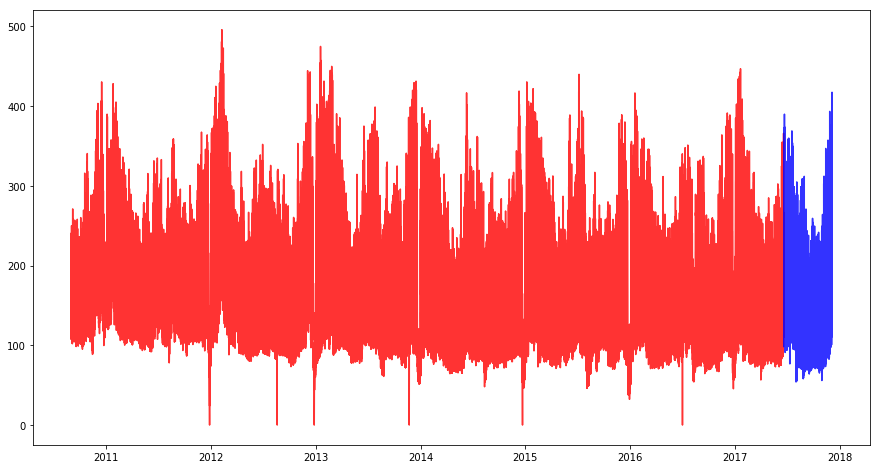

In [24]:
val_cutoff = '1-1-2017 00:00:00'
test_cutoff = '6-19-2017 23:59:59'

feats_df.index=feats_df.Timestamp
plt.figure(figsize=(15,8))

XY_plot = feats_df[feats_df.data_set==0]
plt.plot(XY_plot.index, XY_plot.Values, alpha=0.8, c= 'r')

XY_plot = feats_df[feats_df.data_set==1]
plt.plot(XY_plot.index, XY_plot.Values, alpha=0.8, c='k')

XY_plot = feats_df[feats_df.data_set==3]
plt.plot(XY_plot.index, XY_plot.Values, alpha=0.8, c= 'b')
